In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
from glob import glob
import pickle

#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.
FIG_SIZE = (15,10)

In [45]:
train_df = pd.read_csv("D:/dacon/covid19/data/train_data.csv")

In [46]:
test_df = pd.read_csv("D:/dacon/covid19/data/test_data.csv")

In [ ]:
#load
with open("D:/dacon/covid19/data/pickles/train_dict.pickle","rb") as fr:
    train_dict = pickle.load(fr)

with open("D:/dacon/covid19/data/pickles/test_dict.pickle","rb") as fr:
    test_dict = pickle.load(fr)

In [48]:
print('gender : \n\n',train_df['gender'].value_counts())
print('respiratory_condition : \n\n',train_df['respiratory_condition'].value_counts())
print('fever_or_muscle_pain : \n\n',train_df['fever_or_muscle_pain'].value_counts())
print('covid19 : \n\n',train_df['covid19'].value_counts())

gender : 

 male      2606
female    1173
other       26
Name: gender, dtype: int64
respiratory_condition : 

 0    3254
1     551
Name: respiratory_condition, dtype: int64
fever_or_muscle_pain : 

 0    3483
1     322
Name: fever_or_muscle_pain, dtype: int64
covid19 : 

 0    3499
1     306
Name: covid19, dtype: int64


In [49]:
train_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0
...,...,...,...,...,...,...
3800,3801,53,male,0,0,0
3801,3802,25,male,0,0,0
3802,3803,26,female,0,0,0
3803,3804,27,female,0,0,0


In [50]:
train_df[['gender','respiratory_condition','fever_or_muscle_pain']] = train_df[['gender','respiratory_condition','fever_or_muscle_pain']].astype('category')

In [51]:
test_df[['gender','respiratory_condition','fever_or_muscle_pain']] = test_df[['gender','respiratory_condition','fever_or_muscle_pain']].astype('category')

In [52]:
train_df=pd.get_dummies(train_df,drop_first=True)

In [62]:
train_df.columns = ['id', 'age','covid19','gender_male', 'gender_other', 'respiratory_condition',
       'fever_or_muscle_pain']

In [63]:
train_df

,id,age,covid19,gender_male,gender_other,respiratory_condition,fever_or_muscle_pain
0,1,24,0,0,0,0,1
1,2,51,0,1,0,0,0
2,3,22,0,1,0,0,0
3,4,29,0,0,0,1,0
4,5,23,0,1,0,0,0
...,...,...,...,...,...,...,...
3800,3801,53,0,1,0,0,0
3801,3802,25,0,1,0,0,0
3802,3803,26,0,0,0,0,0
3803,3804,27,0,0,0,0,0


In [54]:
test_df=pd.get_dummies(test_df,drop_first=True)

In [59]:
test_df.columns = ['id', 'age', 'gender_male', 'gender_other', 'respiratory_condition',
       'fever_or_muscle_pain']

In [64]:
test_df

,id,age,gender_male,gender_other,respiratory_condition,fever_or_muscle_pain
0,3806,48,0,0,1,0
1,3807,24,0,0,0,0
2,3808,29,1,0,0,0
3,3809,39,0,0,0,0
4,3810,34,1,0,0,0
...,...,...,...,...,...,...
5727,9533,43,1,0,0,0
5728,9534,48,0,0,0,1
5729,9535,44,0,0,0,0
5730,9536,25,0,0,0,0


In [65]:
train_df.to_csv("./data/train_data_pre.csv",index=False)
test_df.to_csv("./data/test_data_pre.csv",index=False)

In [39]:
healthy_list = train_df[train_df['covid19']==0]['id']
covid_list = train_df[train_df['covid19']==1]['id']

In [40]:
# healthy 5
healthy_dats = [ ]
covid_dats = []


for idx,key in enumerate(healthy_list):
    if idx >4:
        break
    num = key
    num_str = str(num)
    healthy_dats.append(train_dict[num_str.zfill(5)+'.wav'] )

    
for idx,key in enumerate(covid_list):
    if idx >4:
        break
    num = key
    num_str = str(num)
    covid_dats.append(train_dict[num_str.zfill(5)+'.wav'])

NameError: name 'train_dict' is not defined

# spectrogram

Text(0.5, 0, 'Time')

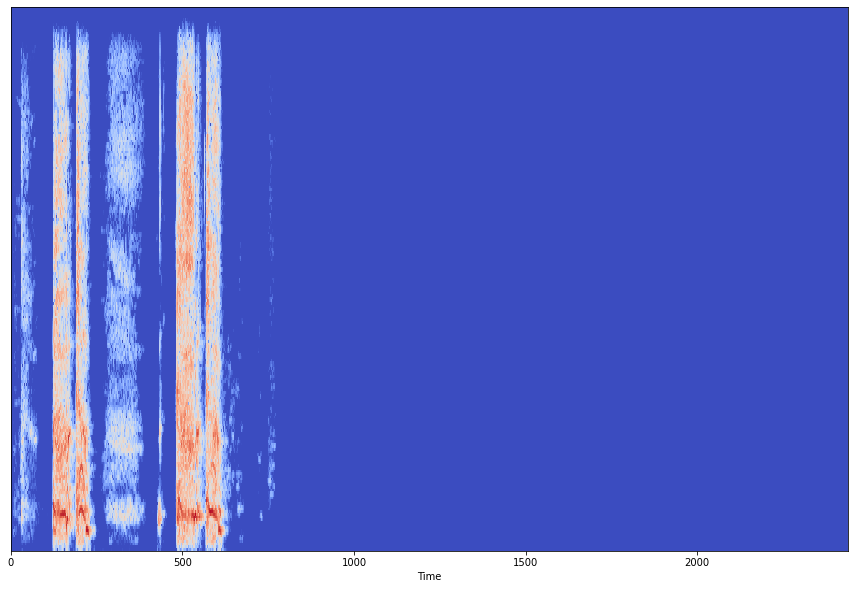

In [41]:
stft = librosa.stft(healthy_dats[0], win_length=win_length,n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

Text(0.5, 0, 'Time')

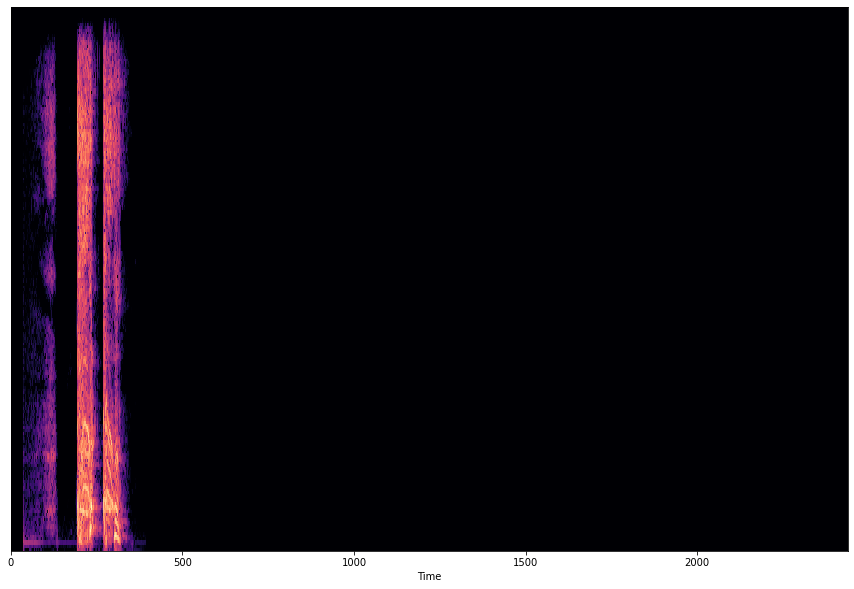

In [42]:
stft = librosa.stft(healthy_dats[1], win_length=win_length,n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

Text(0.5, 0, 'Time')

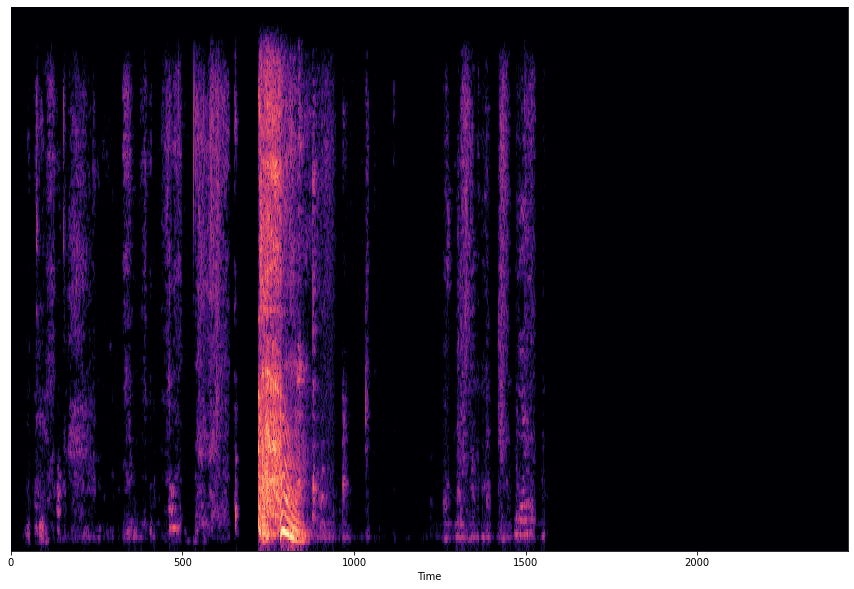

In [44]:
stft = librosa.stft(covid_dats[0], win_length=win_length,n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

Text(0.5, 0, 'Time')

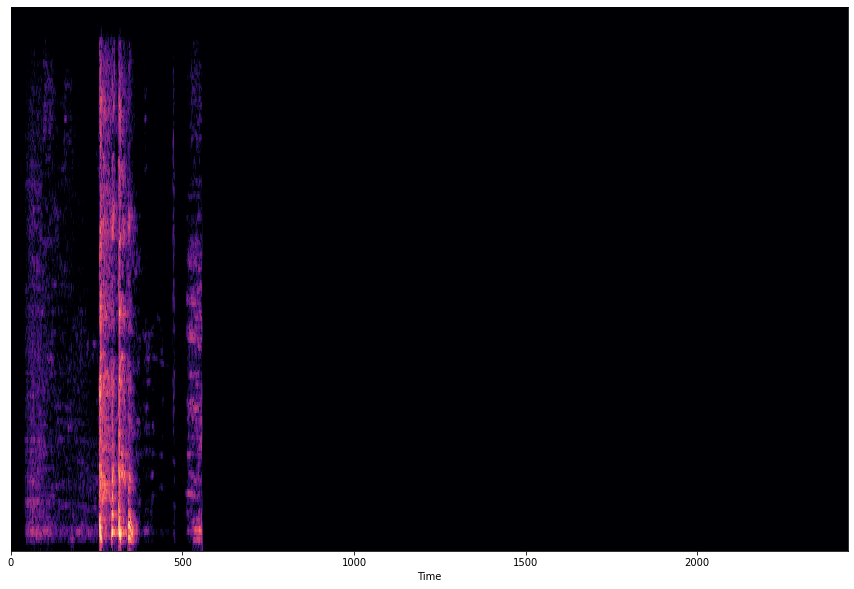

In [43]:
stft = librosa.stft(covid_dats[1], win_length=win_length,n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

# mel spec

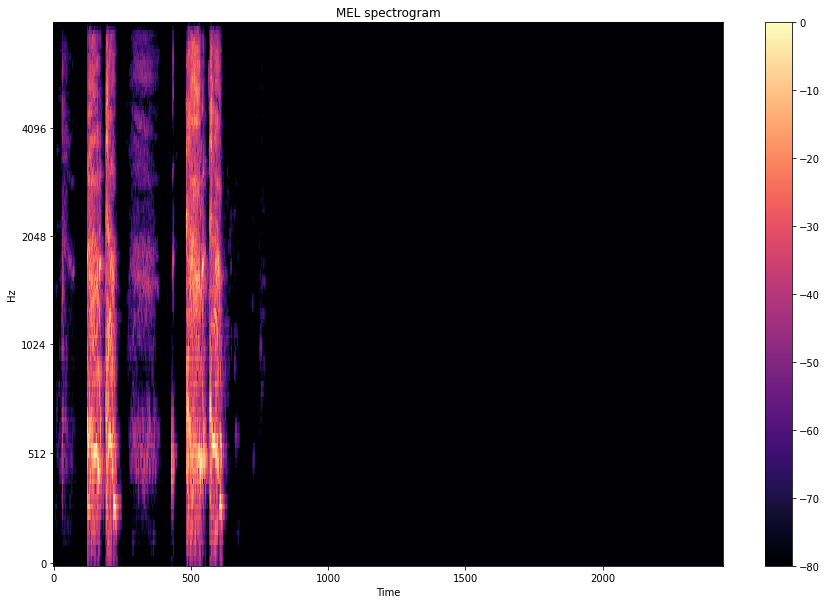

(128, 2439)


In [37]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs


mel = librosa.feature.melspectrogram(y=healthy_dats[0], sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
mel = librosa.core.power_to_db(mel,ref=np.max)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='frames', y_axis='mel')
plt.xlabel("Time")

plt.ylabel("Hz")
plt.colorbar()
plt.title("MEL spectrogram")

# show plots
plt.show()
print(mel.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

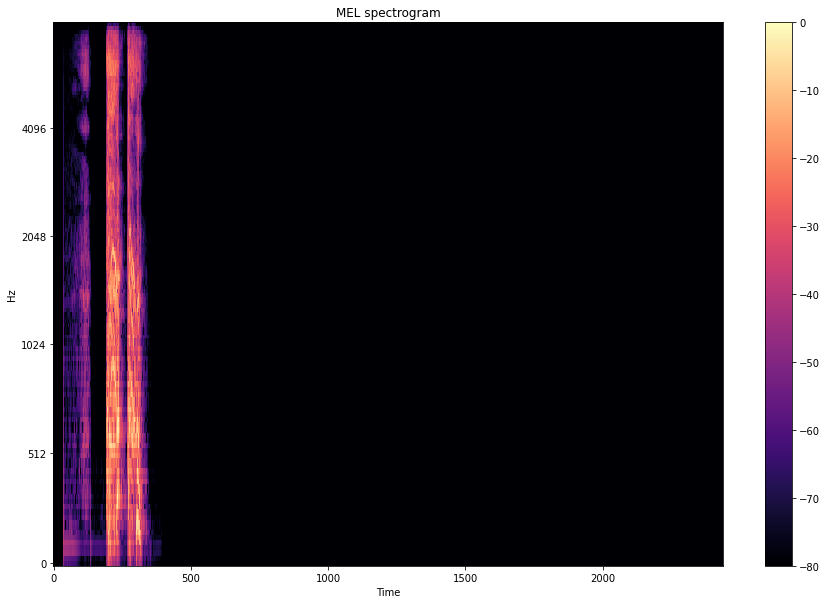

(128, 2439)


In [38]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs


mel = librosa.feature.melspectrogram(y=healthy_dats[1], sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
mel = librosa.core.power_to_db(mel,ref=np.max)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='frames', y_axis='mel')
plt.xlabel("Time")

plt.ylabel("Hz")
plt.colorbar()
plt.title("MEL spectrogram")

# show plots
plt.show()
print(mel.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

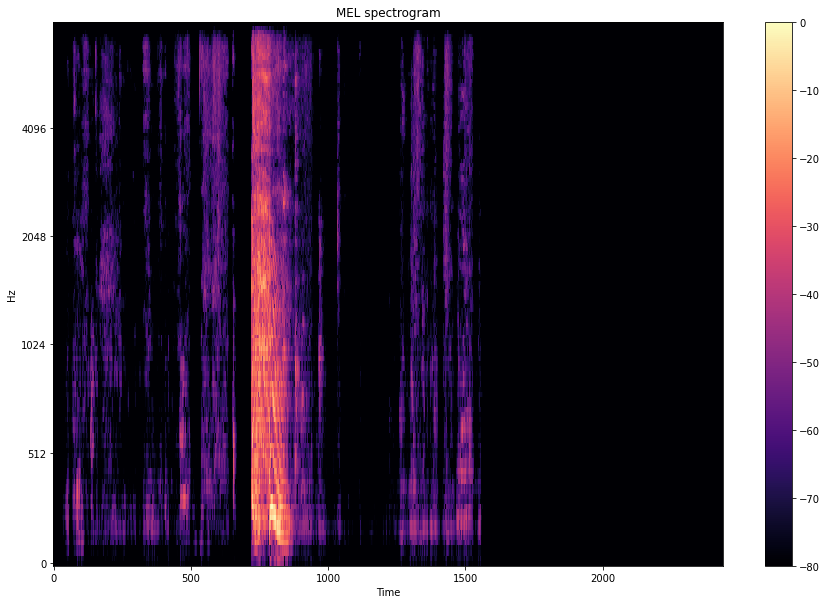

(128, 2439)


In [39]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs


mel = librosa.feature.melspectrogram(y=covid_dats[0], sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
mel = librosa.core.power_to_db(mel,ref=np.max)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='frames', y_axis='mel')
plt.xlabel("Time")

plt.ylabel("Hz")
plt.colorbar()
plt.title("MEL spectrogram")

# show plots
plt.show()
print(mel.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

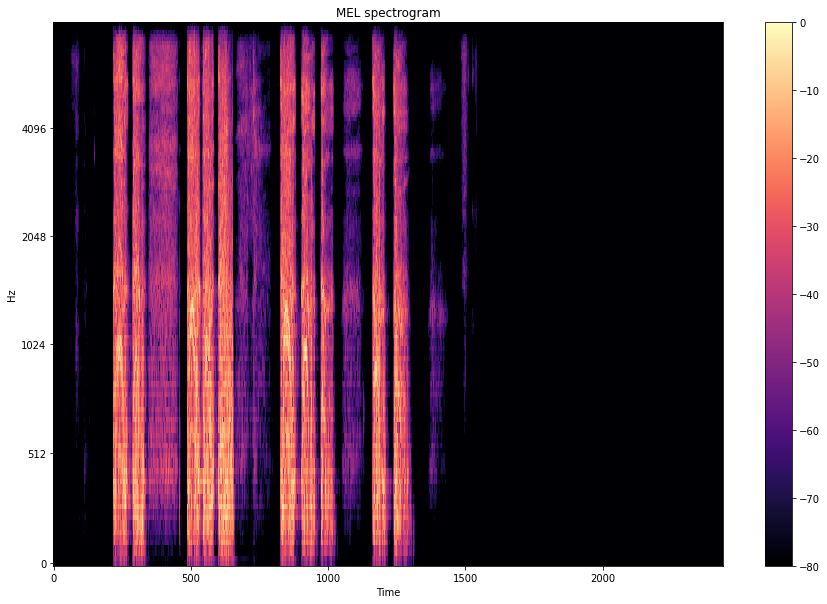

(128, 2439)


In [40]:
# MFCCs
#librosa에서는 stft로 수행해서, 시간 정보를 보존하기 위해 frame단위로 fft 수행.
# extract 13 MFCCs


mel = librosa.feature.melspectrogram(y=covid_dats[2], sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
mel = librosa.core.power_to_db(mel,ref=np.max)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='frames', y_axis='mel')
plt.xlabel("Time")

plt.ylabel("Hz")
plt.colorbar()
plt.title("MEL spectrogram")

# show plots
plt.show()
print(mel.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

# mfcc

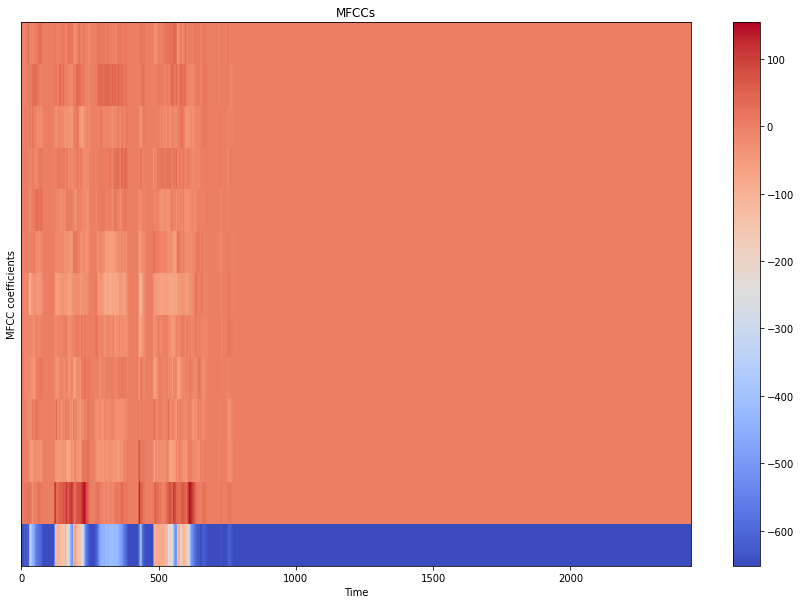

(13, 2439)


In [33]:
# MFCCs
# extract 13 MFCCs

MFCCs = librosa.feature.mfcc(y=healthy_dats[0], sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

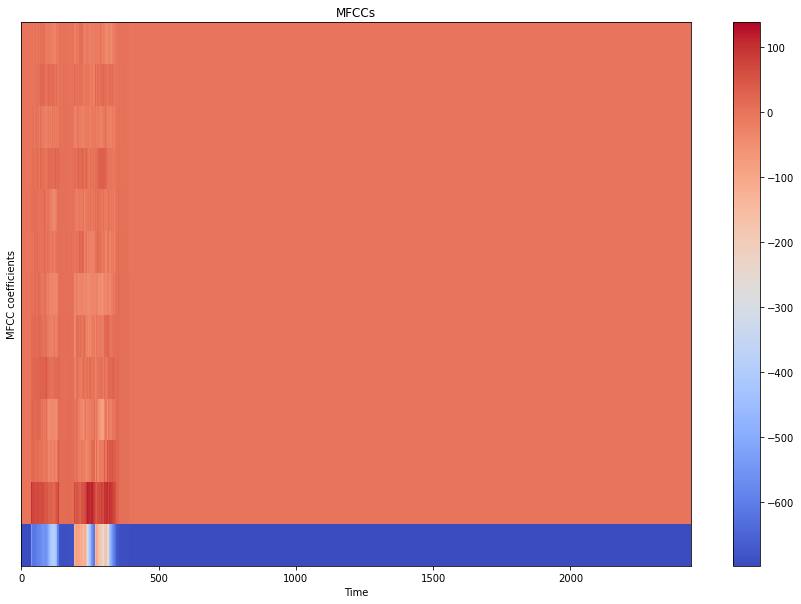

(13, 2439)


In [34]:
# MFCCs
# extract 13 MFCCs

MFCCs = librosa.feature.mfcc(y=healthy_dats[1], sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

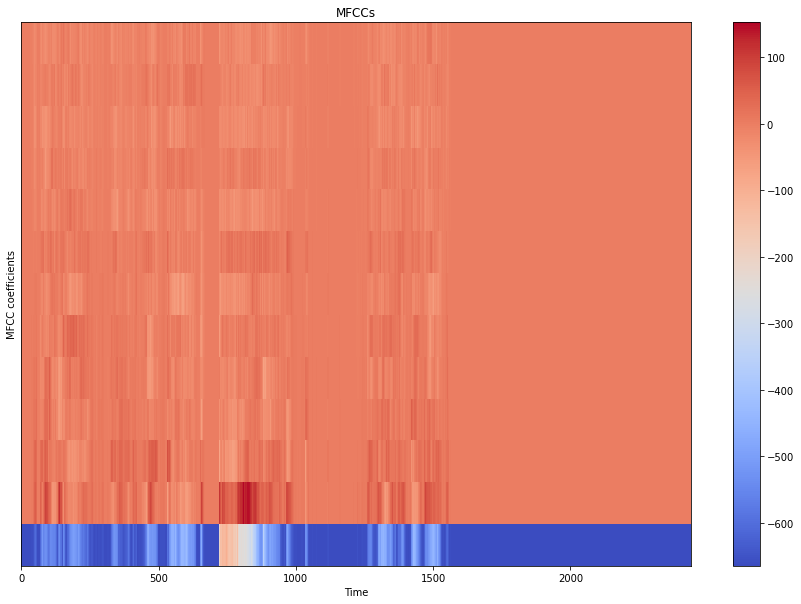

(13, 2439)


In [36]:
# MFCCs
# extract 13 MFCCs

MFCCs = librosa.feature.mfcc(y=covid_dats[0], sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length,x_axis='frames')
plt.xlabel("Time")

plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()
print(MFCCs.shape)
# 497 frame(time step).
# 497 frame 만큼 RNN에서 시점을 가진다.

# lpc